In [1]:
import json
import os
from utils import utils
import random
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(1)

### Load the dataset

In [2]:
data_dir = "/net/projects/veitch/prompt_distributions/data"
data_file = "prompt_completions_gpt-4-1106-preview_subset300_seed123_numtokens40_next1_temp0.7_job23632.json"

with open(os.path.join(data_dir, data_file), "r") as f:
    dataset = json.load(f)

print(len(dataset))

300


In [3]:
dataset[0]

{'review': "I won't claim to be a fan of Ralph Bakshi, because i am not. I have only watched 5 of his animated films so far: Coonskin, Wizards, Fritz the Cat",
 'next_text': ' and',
 'label': 1,
 'sentiment': 'positive',
 'flipped_sentiment': 'negative',
 'baseline_query': "Movie Review: \nI won't claim to be a fan of Ralph Bakshi, because i am not. I have only watched 5 of his animated films so far: Coonskin, Wizards, Fritz the Cat\n[Finish this movie review.]\nCompletion:  and",
 'baseline_query_completion': "Fire and Ice, and The Lord of the Rings. Each of these films showcases Bakshi's groundbreaking approach to adult-oriented animation, blending satirical content with gritty, often controversial subject matter.\n\nCoonskin, while perhaps his most contentious work, is a satirical take on race relations that combines live-action with animation. This film is challenging and uncomfortable, but its boldness and raw portrayal of stereotypes are meant to provoke thought rather than provi

In [4]:
pos_reviews = [d for d in dataset if d["sentiment"] == "positive"]
neg_reviews = [d for d in dataset if d["sentiment"] == "negative"]

### Load Model

In [5]:
import torch
from nnsight import LanguageModel
from utils import utils

In [6]:
device = 'cuda:0'
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [7]:
model_name = 'google/gemma-2b-it'
hidden_dim = 2048

model = LanguageModel(model_name, device_map=device)

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


In [8]:
model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

### Load directions

In [9]:
saved_directions = f"/net/projects/veitch/geometry_llms/directions/intervention/sentiment_{model_name.split('/')[-1]}.pt"
# load the directions
directions = torch.load(saved_directions)
print(directions.shape)

torch.Size([5, 2048])


In [10]:
print(directions[0].squeeze().shape)

torch.Size([2048])


### Sample a positive base_prompt and negative source_prompt

In [11]:
# sample a random review as the base prompt
base_sample = random.choice(pos_reviews)

base_prompt = base_sample["baseline_query"]
base_prompt

'Movie Review: \n***SPOILERS*** All too, in real life as well as in the movies, familiar story that happens to many young men who are put in a war zone with a gun, or rifle\n[Finish this movie review.]\nCompletion: ,'

In [12]:
# sample a random review as the source prompt
source_sample = random.choice(neg_reviews)
source_prompt = source_sample["baseline_query"]
source_prompt

'Movie Review: \nOnly one thing could have redeemed this sketch. A healthy gunfight between the happy couple, the exotic model at the delicatessen, and the old-timer from the motel who was (it would\n[Finish this movie review.]\nCompletion:  have'

In [13]:
# Tokenize the prompts
base_tokens = model.tokenizer([base_prompt,source_prompt], return_tensors="pt", padding="longest")
base_tokens = model.tokenizer(base_prompt, return_tensors="pt")
source_tokens = model.tokenizer(source_prompt, return_tensors="pt")

# Compare the lengths
print(base_tokens.input_ids.shape)
print(source_tokens.input_ids.shape)

torch.Size([1, 54])
torch.Size([1, 58])


### Compute token-wise, additive weights using directional patching

In [14]:
weights = utils.get_patching_weights_nnsight(model, base_prompt, source_prompt, directions[0])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Modified source sequence length: 54


In [15]:
weights.shape

torch.Size([1, 54, 1])

### Plot the weights (I don't think the tokens are aligned properly right now)

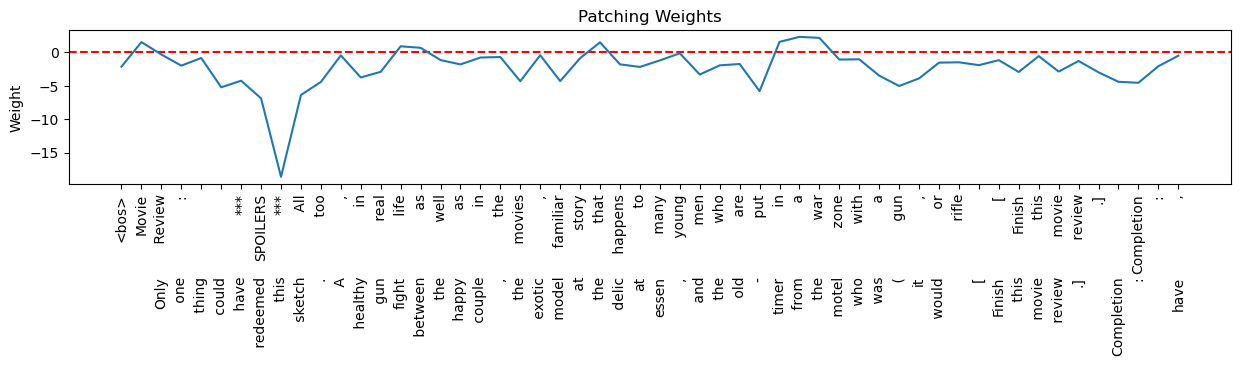

In [16]:
# Decode each base token individually for visualization
decoded_base = [model.tokenizer.decode([tid]) for tid in base_tokens.input_ids.squeeze()]
decoded_source = [model.tokenizer.decode([tid]) for tid in source_tokens.input_ids.squeeze()]
decoded_source = decoded_source[-len(decoded_base):]
assert len(decoded_base) == len(decoded_source)

# Plot the weights with a line plot, with each base token listed beneath
numpy_weights = weights.detach().cpu().squeeze().numpy()
plt.figure(figsize=(15,2))
# Add dashed red line to demarcate the negative weights
plt.axhline(0, color='red', linestyle='--')
plt.plot(numpy_weights)
# plt.xlabel('Token Index')
plt.ylabel('Weight')
plt.title('Patching Weights')
plt.xticks(range(len(numpy_weights)), decoded_base, rotation='vertical', fontsize=10)
# Manually add each label
for index, source in enumerate(decoded_source):
    plt.text(index, numpy_weights.min() * 1.8, source, rotation='vertical', ha='center', fontsize=10, va='top')
plt.show()

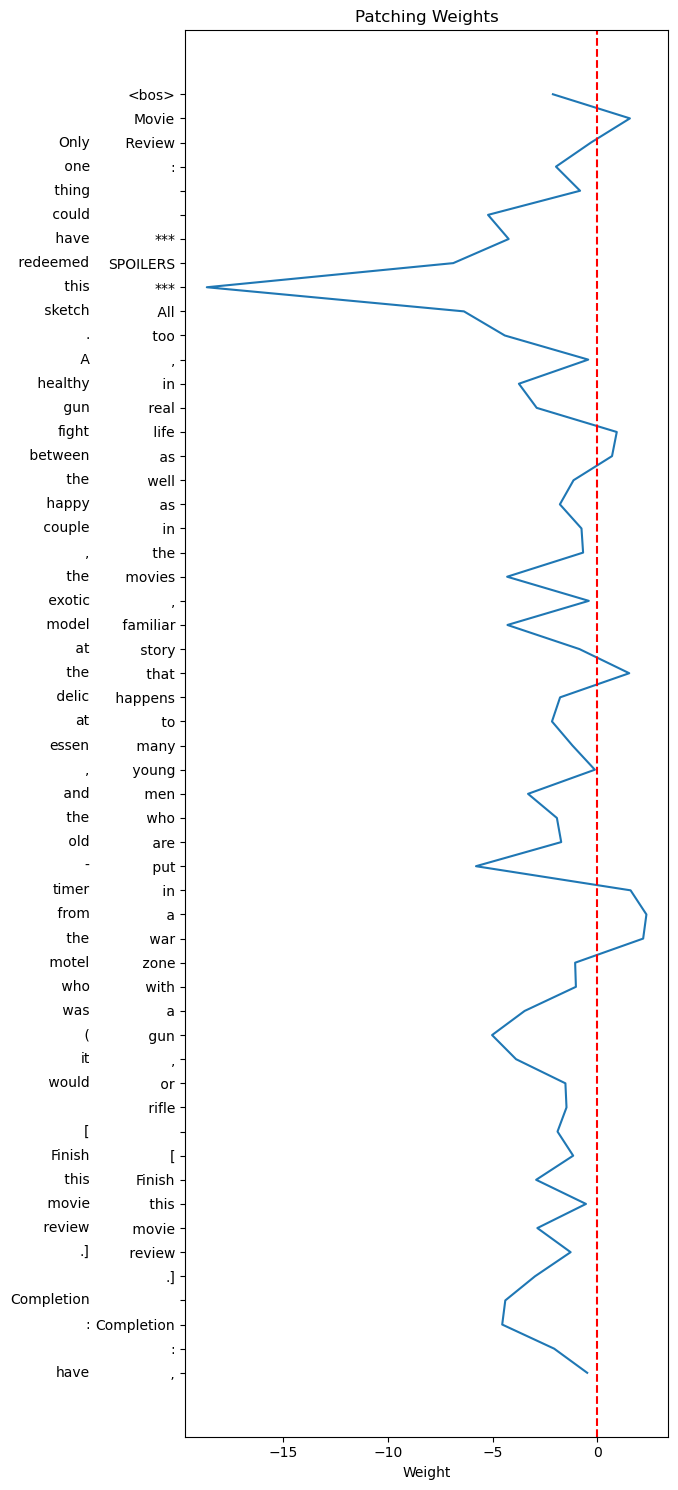

In [17]:
# Exactly the same, just flipped 90 degrees

# Plot the weights with a line plot, now vertically
numpy_weights = weights.detach().cpu().squeeze().numpy()
plt.figure(figsize=(7, 15))  # Adjusted figure size for vertical layout
plt.plot(numpy_weights, range(len(numpy_weights)))  # Switch x and y

# Add dashed red line to demarcate the negative weights
plt.axvline(0, color='red', linestyle='--')

# Label setup for vertical layout
plt.xlabel('Weight')
plt.title('Patching Weights')

# Set y-ticks for token labels
plt.yticks(range(len(numpy_weights)), decoded_base, fontsize=10)

# Manually add each label for the source tokens
for index, source in enumerate(decoded_source):
    plt.text(numpy_weights.min() * 1.3, index, source, rotation='horizontal', ha='right', fontsize=10, va='center')

plt.gca().invert_yaxis()  # Invert y-axis to have the plot go downward
plt.tight_layout()
plt.show()